#### Functions for calculating cell-cell contacts

In [6]:
@numba.njit
def circle_intersect_length(c1, c2, r):
    """Length of the intersection between two circles of radius `r`."""
    
    # Get distance between circle centers
    d = np.linalg.norm(c1 - c2)
    
    # Get length of interface, with a floor of zero
    ell2 = np.maximum(r**2 - (d**2)/4, 0)
    return 2 * np.sqrt(ell2)
    
@numba.njit
def circle_intersect_length2(c1, c2, r1, r2):
    """Length of the intersection between two circles of radius `r1` and `r2`."""
    
    # Get distance between circle centers
    d = np.linalg.norm(c1 - c2)
    
    # Check if circles do not intersect
    if d >= (r1 + r2):
        return 0
    
    # Else, calculate intersection length
    return 2 * r1 * np.sqrt(1 - ((r1**2 + d**2 - r2**2) / (2 * r1 * d))**2)

In [7]:
@numba.njit
def get_L_vals(xs, vs, vertices):
    """"""
    # Make matrix cell-cell contact lengths
    
    n_l = 0
    for v1, v2 in vs:
        if (v1 >= 0) & (v2 >= 0):
            n_l += 1
    
    Lij = np.zeros((n_l, 2), dtype=np.int_)
    L_vals = np.empty(n_l, dtype=np.float32)
    
    k = 0
    for i, x12 in enumerate(xs):
        v1, v2 = vs[i]
#         v1, v2 = vs
#         cs, (v1, v2)
        # Infinite Voronoi edges have zero length
        if (v1 < 0) | (v2 < 0):
            continue
        
        # Get length of cell-cell ridge
        ell = np.linalg.norm(vertices[v1] - vertices[v2])
        Lij[k] = x12
        L_vals[k] = ell
        
        k += 1
        
    return Lij, L_vals

def make_L(vor):
    """csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
    a[row_ind[k], col_ind[k]] = data[k]."""
    n = vor.npoints
    xs = vor.ridge_points
    vs = np.array(vor.ridge_vertices)
    vertices = vor.vertices
    
    Lij, L_vals = get_L_vals(xs, vs, vertices)
    L = csr_matrix((L_vals, (*Lij.T,)), shape=(n, n))
#     return n, Lij, L_vals
    return L + L.T

In [8]:
@numba.njit
def get_L_vals_gaps(xs, vs, pts, vertices, cr=1/np.sqrt(3)):
    """
    Cell-cell contact lengths for cell radius `cr`.
    """
    # Make matrix cell-cell contact lengths
    n_l = 0
    for v1, v2 in vs:
        if (v1 >= 0) & (v2 >= 0):
            n_l += 1
    
    Lij = np.zeros((n_l, 2), dtype=np.int_)
    L_vals = np.empty(n_l, dtype=np.float32)
    
    k = 0
    for i, x_pair in enumerate(xs):
        v1, v2 = vs[i]
#         v1, v2 = vs
#         cs, (v1, v2)
        # Infinite Voronoi edges have zero length
        if (v1 < 0) | (v2 < 0):
            continue
        
        # Get length of Voronoi ridge
        ell_vor = np.linalg.norm(vertices[v1] - vertices[v2])
        
        # Get length of circles intersection
        ell_cir = circle_intersect_length(pts[x_pair[0]], pts[x_pair[1]], cr)
        
        # Store the lower value of interface length
        L_vals[k] = np.minimum(ell_vor, ell_cir)
        
        # Store point indices
        Lij[k] = x_pair

        k += 1
        
    return Lij, L_vals

def make_L_gaps(vor, cr):
    """
    """
    n = vor.npoints
    xs = vor.ridge_points
    vs = np.array(vor.ridge_vertices)
    pts = vor.points
    vertices = vor.vertices
    
    Lij, L_vals = get_L_vals_gaps(xs, vs, pts, vertices, cr=cr)
    L = csr_matrix((L_vals, (*Lij.T,)), shape=(n, n))

    return L + L.T

#### Density gradient functions

In [9]:
# def dens_lin(p, findens=2, loc=10):
#     """Linear density gradient."""
#     a = (findens - 1) / loc
#     return 1 + a * p

# def r_lin(r, findens=2, loc=10):
#     a = (1/np.sqrt(findens) - 1) / loc
#     return 1 + a * r

In [10]:
# def r_exp(r, maxdens=2, loc=10):
#     """Exponential density gradient."""
#     a = np.log(np.sqrt(maxdens))/loc
#     return np.exp(-a*r)

# def r_exp_int(r, maxdens=2, loc=10):
#     """Integral of r_exp. Maps a distance to a new 
#     distance under an exponential density gradient."""
#     a = np.log(np.sqrt(maxdens))/loc
#     return 1/(-a) * (np.exp(-a*r) - 1)

In [33]:
# def exp_dens(y, rho_0, rho_k, y_k):
#     a = np.log(rho_0 / rho_k) / np.abs(y_k)
#     return rho_0 * np.exp(-a * np.abs(y))


# def map_xy_exp_dens(xy, rho_0, rho_k, y_k):
#     a = np.log(rho_0 / rho_k) / np.abs(y_k)
#     yp = (
#         np.sign(xy[:, 1])
#         * (2 / (a * np.sqrt(rho_0)))
#         * (np.exp(a * np.abs(xy[:, 1]) / 2) - 1)
#     )
#     xp = xy[:, 0] / np.sqrt(rho_0) * np.exp(a * np.abs(xy[:, 1]) / 2)
    
#     return np.array([xp, yp]).T


# def map_xy_exp_dens_t(xy, nt, rho_0_t0, rho_0_tfin, rho_k_t0, rho_k_tfin, y_k):
#     rho_0_t = np.linspace(rho_0_t0, rho_0_tfin, nt)
#     rho_k_t = np.linspace(rho_k_t0, rho_k_tfin, nt)
#     return np.array(
#         [map_xy_exp_dens(xy, r0, rk, y_k) for r0, rk in zip(rho_0_t, rho_k_t)]
#     )

In [360]:
# # First time-unit and last time-unit have constant density
# tlin_span = 3
# nt_lin = int(tlin_span * nt_t)

In [361]:
# rho_0_t0 = 4.2
# rho_0_tfin = 1.5 * rho_0_t0

# Set density at a reference location 
# rho_k_t0   = rho_0_t0/8
# rho_k_tfin = rho_0_tfin * (5/6)

# Set reference y-value
# y_k = 100

In [375]:
# rho_0_t0, rho_0_tfin, rho_k_t0, rho_k_tfin

In [376]:
# X_t_lin = map_xy_exp_dens_t(X, nt_lin, rho_0_t0, rho_0_tfin, rho_k_t0, rho_k_tfin, y_k)

# X_t = np.concatenate(
#     [
# #         np.repeat(X_t_lin[:1], nt_t, axis=0),
#         X_t_lin,
#         np.repeat(X_t_lin[-1:], nt - nt_lin, axis=0),
#     ]
# )

In [377]:
# X_t = np.array([x - np.array([0, y_k]) for x in X_t])

In [ ]:
# ymap_ratio = ymap_t/X[:rows,1]
# ymap_ratio[:, 0] = r_y_t(0, t, psi, y_k, rho_bar, rho_max)

# ymap_t = np.tile(ymap_t, (1, cols))
# ymap_ratio = np.tile(ymap_ratio, (1, cols))

# xmap_t = X[:, 0] * ymap_ratio

In [380]:
# # Assign senders at regular intervals (~2% of cells)
# sender_idx = []
# for i in range(n):
#     row = i % rows
#     col = i // rows
#     if (row % 8 == 1) & (col % 8 == 0):
#         sender_idx.append(i)
# sender_idx = np.array(sender_idx)

In [548]:
# # Get plotting window
# xlim = X_t[-1, :, 0].min() - 1, X_t[-1, :, 0].max() + 1
# ylim = X_t[-1, :, 1].min() - 1, X_t[-1, :, 1].max() + 1

In [915]:
# tc_masks = X_masks.copy()
# tc_masks[:, sender_idx] = False

# tc_y_pos_t = [y[m] for y, m in zip(X_t[-1, :, 1], tc_masks)]
# tc_fluor_t = [s[m] for s, m in zip(S_t, tc_masks)]

In [916]:
# tc_masks_static = np.tile(X_masks[-1], (nt,1))
# tc_masks_static[:, sender_idx] = False
# tc_y_pos_t = np.tile(X_t[-1, :, 1][tc_masks_static[0]], (nt,1))
# tc_fluor_t = [s[tc_masks_static[0]] for s in S_t]

In [917]:
# for i, t_ in enumerate(t_samples):
# #     idx_hist = np.digitize(tc_y_pos_t[t_], bins = y_bins)
#     for ib in range(nbins):
# #         tc_fluor_t_bins[i, ib] = tc_fluor_t[t_][idx_hist == (ib + 1)].mean()
#         tc_fluor_t_bins[i, ib] = S_t[]
#     normfluor = np.array(tc_fluor_t_bins[i] / tc_fluor_t_bins[i].max())
#     normfluor = np.nan_to_num(normfluor)
#     tc_normfluor_t_bins[i] = normfluor

In [942]:
# data = pd.DataFrame(
#     tc_fluor_t_bins, 
#     columns=y_bins[1:] - (np.diff(y_bins)/2), 
#     index=t[t_samples],
# ).reset_index().melt(id_vars="index")
# data.columns = ["simulation time", "position", "mean fluorescence"]

:NdOverlay   [simulation time]
   :Curve   [position]   (mean fluorescence,simulation time)
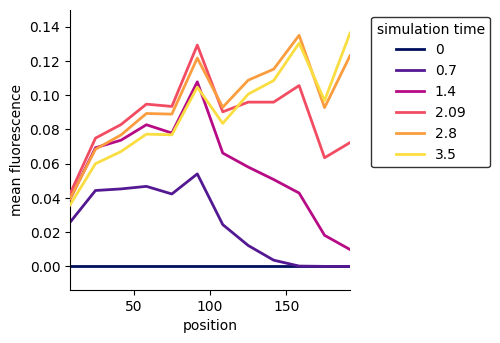

In [944]:
# %%capture --no-stdout --no-display

# cycle = lsig.sample_cycle(cc.linear_bmy_10_95_c71[:-20], nt_sample)

# p1 = hv.Curve(
#     data=data,
#     kdims=["position"],
#     vdims=["mean fluorescence", "simulation time"],
# ).groupby(
#     "simulation time"
# ).overlay(
# ).opts(
#     legend_position="right"
# ).options(
#     {"Curve": dict(color=cycle)}
# )

# hv.output(p1, dpi=100)